### Case Study 3
**Author:** yz4130


In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import fmin, fmin_bfgs
from matplotlib import cm

#### Utility Pricing Function

Part of the following codes are quoted from the provided sample code

In [4]:
def VG(x, theta, nu, sig):
    return -np.log(1 - 1j*x*theta*nu + nu*(sig*x)**2/2) / nu


def timechangeCF(u, t, y0, kappa, eta, lamda):
    g = np.sqrt(kappa**2 - 2 * lamda**2 * 1j * u)
    log_numer = eta * t * kappa**2 / lamda ** 2
    power = 2 * kappa * eta / lamda**2
    log_denum = power * np.log(np.cosh(g*t/2) + (kappa/g) * np.sinh(g*t/2))
    B = 2j*u / (kappa + g/np.tanh(g*t/2))
    log_phi = log_numer - log_denum + B * y0
    return np.exp(log_phi)
    

def generic_CF(u, params, S0, r, q, T, model):   
    
    if model == 'Heston':
        kappa = params[0]
        theta = params[1]
        sigma = params[2]
        rho = params[3]
        v0 = params[4]
        
        tmp = (kappa - 1j * rho * sigma * u)
        g = np.sqrt((sigma**2) * (u**2 + 1j*u) + tmp**2)
        pow1 = 2 * kappa * theta / (sigma**2)
        numer1 = (kappa * theta * T * tmp) / (sigma**2) + 1j * u * T * (r-q) + 1j * u * np.log(S0)
        log_denum1 = pow1 * np.log(np.cosh(g*T/2) + (tmp/g) * np.sinh(g*T/2))
        tmp2 = ((u*u + 1j*u) * v0) / (g / np.tanh(g*T/2) + tmp)
        log_phi = numer1 - log_denum1 - tmp2
        phi = np.exp(log_phi)

    elif model == 'VGSA':
        sigma = params[0]
        nu = params[1]
        theta = params[2]
        kappa = params[3]
        eta = params[4]
        lamda = params[5]

        num = timechangeCF(-1j*VG(u, theta, nu, sigma), T, 1/nu, kappa, eta, lamda)
        denum = timechangeCF(-1j*VG(-1j, theta, nu, sigma), T, 1/nu, kappa, eta, lamda) ** (1j * u)
        exp =  np.exp(1j * u * (np.log(S0) + (r-q) * T))
        phi = exp * num / denum

    return phi

In [5]:
def genericFFT(params, S0, K, r, q, T, alpha, eta, n, model):
    
    N = 2**n
    
    # step-size in log strike space
    lda = (2*np.pi/N)/eta
    
    #Choice of beta
    #beta = np.log(S0)-N*lda/2
    beta = np.log(K)
    
    # forming vector x and strikes km for m=1,...,N
    km = np.zeros((N))
    xX = np.zeros((N))
    
    # discount factor
    df = np.exp(-r*T)
    
    nuJ = np.arange(N)*eta
    psi_nuJ = generic_CF(nuJ-(alpha+1)*1j, params, S0, r, q, T, model) / ((alpha + 1j*nuJ)*(alpha+1+1j*nuJ))
    
    for j in range(N):  
        km[j] = beta+j*lda
        if j == 0:
            wJ = (eta/2)
        else:
            wJ = eta
        xX[j] = np.exp(-1j*beta*nuJ[j])*df*psi_nuJ[j]*wJ
     
    yY = np.fft.fft(xX)
    cT_km = np.zeros((N))  
    for i in range(N):
        multiplier = np.exp(-alpha*km[i])/np.pi
        cT_km[i] = multiplier*np.real(yY[i])
    
    return km, cT_km


#### Data Preprocessing

The data is obtained from https://www.cboe.com/delayed_quotes/spx/quote_table, downloaded on Mar 31.

Expiration type is selected to be "Standard" (each month will have one maturity date, i.e. one slice). Time ranges from 2022 May to 2023 April. 

Option Range is selected to be "All"

After downloading the data, out of money options will be selected to conduct calibration

In [6]:
# NEED TO CHANGE THE PATH IF RUNNING ON OTHER COMPUTERES
dirpath = '/Users/Yi/Desktop/spxData'
month = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
filename = ['spx_quotedata_' + i + '.csv' for i in month]
path = [os.path.join(dirpath, f) for f in filename]

In [7]:
# raw data
test = pd.read_csv('/Users/Yi/Desktop/spxData/spx_quotedata_Apr.csv', skiprows=3)
test.head()

,Expiration Date,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,...,Puts,Last Sale.1,Net.1,Bid.1,Ask.1,Volume.1,IV.1,Delta.1,Gamma.1,Open Interest.1
0,Fri Apr 21 2023,SPX230421C00200000,4252.94,0.0,4282.0,4307.1,0,1.6087,0.9992,0.0,...,SPX230421P00200000,0.22,0.0,0.00,0.6,0,1.0135,-0.0003,0.0,1
1,Fri Apr 21 2023,SPX230421C00400000,4058.24,0.0,4086.8,4111.5,0,1.2053,0.9987,0.0,...,SPX230421P00400000,0.00,0.0,0.35,1.1,0,0.8434,-0.0007,0.0,0
2,Fri Apr 21 2023,SPX230421C00600000,0.00,0.0,3892.1,3916.4,0,0.9962,0.9981,0.0,...,SPX230421P00600000,1.70,0.0,0.95,2.0,0,0.7514,-0.0014,0.0,2
3,Fri Apr 21 2023,SPX230421C00800000,0.00,0.0,3697.9,3721.8,0,0.8596,0.9972,0.0,...,SPX230421P00800000,0.00,0.0,1.75,3.3,0,0.6838,-0.0023,0.0,0
4,Fri Apr 21 2023,SPX230421C01000000,0.00,0.0,3503.8,3527.2,0,0.7569,0.9958,0.0,...,SPX230421P01000000,0.00,0.0,3.00,4.7,0,0.6282,-0.0036,0.0,0


In [8]:
# read in raw csv file, filter out the OTM options that interested
def clean(spot, currentTime, rate, f):
    data = pd.read_csv(f, skiprows=3)
    
    data['Expiration Date'] = pd.to_datetime(data['Expiration Date'])
    T = (data['Expiration Date'][0] - currentTime).days / 365
    data['Maturity'] = T
    
    # use mid point of ask and bid as the option price
    data['CallPrice'] = (data['Bid'] + data['Ask']) / 2
    data['PutPrice'] = (data['Bid.1'] + data['Ask.1']) / 2
    
    # calculate divident rate based on put-call parity (find the most ATM)
    idx = np.argmin(np.abs(data['Strike'] - spot))
    nearest = data.iloc[idx, :]
    def find_div(c, p, r, T, K, S):
        return -np.log((c - p + K * np.exp(-r*T)) / S) / T
    data['Dividend'] = find_div(nearest['CallPrice'], nearest['PutPrice'], rate, T, nearest['Strike'], spot)

    # extract OTM option (20% out of moneyness)
    c = data[['CallPrice', 'Strike', 'Maturity', 'Dividend', 'Bid', 'Ask']]
    # c = c[c['Strike'] > spot].reset_index(drop=True)
    c = c[(c['Strike'] < spot*1.2) & (c['Strike'] > spot)].reset_index(drop=True)
    c.columns = ['Price', 'Strike', 'Maturity', 'Dividend', 'Bid', 'Ask']
     
    p = data[['PutPrice', 'Strike', 'Maturity', 'Dividend', 'Bid.1', 'Ask.1']]
    # p = p[p['Strike'] < spot].reset_index(drop=True)
    p = p[(p['Strike'] > 0.8*spot) & (p['Strike'] < spot)].reset_index(drop=True)
    p.columns = ['Price', 'Strike', 'Maturity', 'Dividend', 'Bid', 'Ask']
    
    return c, p

In [9]:
# info on Mar 31, 2022 (the day data was downloaded), global variables
spot = 4530.41
current = pd.to_datetime('Wed Mar 31 2022')
rate = 0.005

# SNAPSHOT
# specify the month we are interested here. For each different month, rerun the following code blocks to produce the corresponding results.
SNAPSHOT = 'Aug'
f = path[month.index(SNAPSHOT)]
call, put = clean(spot, current, rate, f)

print(call.head())
print('Number of Call Options:', len(call))
print('')

print(put.head())
print('Number of Put Options:', len(put))
print('')

print('Total Number of Options:', len(call) + len(put))

    Price  Strike  Maturity  Dividend    Bid    Ask
0  223.55  4540.0  0.386301 -0.003169  221.7  225.4
1  217.10  4550.0  0.386301 -0.003169  215.3  218.9
2  210.35  4560.0  0.386301 -0.003169  209.0  211.7
3  204.10  4570.0  0.386301 -0.003169  202.7  205.5
4  201.05  4575.0  0.386301 -0.003169  199.7  202.4
Number of Call Options: 71

   Price  Strike  Maturity  Dividend   Bid   Ask
0  47.70  3625.0  0.386301 -0.003169  46.9  48.5
1  48.10  3630.0  0.386301 -0.003169  47.3  48.9
2  48.95  3640.0  0.386301 -0.003169  48.1  49.8
3  49.80  3650.0  0.386301 -0.003169  49.0  50.6
4  50.60  3660.0  0.386301 -0.003169  49.8  51.4
Number of Put Options: 110

Total Number of Options: 181


Q: why the dividends are negative? 


#### Cost Function

We utlize the FFT method to price the options based on the given parameters. The results will then be passed to the cost function and cost will be calculated. 

In [10]:
# FrFFT parameter setting
alpha = 1.5
n_FFT = 10
eta = 0.2

# def cost(x0, option, weight, model):
#     obs = len(option)
#     modelPrice = np.zeros(obs)
    
#     for i in range(obs):
        
#         # use average dividend
#         # K, q, T = option['Strike'][i], 0.02, option['Maturity'][i]

#         # use implied dividend from put call parity
#         K, q, T = option['Strike'][i], option['Dividend'][i], option['Maturity'][i]
        
#         km, cT_km = genericFFT(x0, spot, K, rate, q, T, alpha, eta, n_FFT, model)
#         modelPrice[i] = np.interp(np.log(K), km, cT_km)
    
#     if weight == 'Equal':
#         ans = np.sum((option['Price'] - modelPrice) ** 2)

#     elif weight == 'inverseSpread':
#         spread = np.abs(option['Bid'] - option['Ask'])
#         ans = np.sum((option['Price'] - modelPrice)**2 / spread)

#     rmse = np.sqrt(ans/obs)  
#     return rmse


def cost(x0, call_df, put_df, weight, model):
    call_modelPrice = np.zeros(len(call_df))
    put_modelPrice = np.zeros(len(put_df))
    
    for i in range(len(call_df)):
        # use implied dividend from put call parity
        K, q, T = call_df['Strike'][i], call_df['Dividend'][i], call_df['Maturity'][i]
        
        km, cT_km = genericFFT(x0, spot, K, rate, q, T, alpha, eta, n_FFT, model)
        call_modelPrice[i] = np.interp(np.log(K), km, cT_km)
    
    for j in range(len(put_df)):
        K, q, T = put_df['Strike'][j], put_df['Dividend'][j], put_df['Maturity'][j]
        km, cT_km = genericFFT(x0, spot, K, rate, q, T, alpha, eta, n_FFT, model)
        put_modelPrice[j] = np.interp(np.log(K), km, cT_km) + K * np.exp(-rate*T) - spot * np.exp(-q*T)
    
    if weight == 'Equal':
        ans = np.sum((call_df['Price'] - call_modelPrice) ** 2) + np.sum((put_df['Price'] - put_modelPrice) ** 2)

    elif weight == 'inverseSpread':
        call_spread = np.abs(call_df['Bid'] - call_df['Ask'])
        put_spread = np.abs(put_df['Bid'] - put_df['Ask'])
        ans = np.sum((call_df['Price'] - call_modelPrice)**2 / call_spread) + np.sum((put_df['Price'] - put_modelPrice)**2 / put_spread)

    rmse = np.sqrt(ans / (len(call_df) + len(put_df)))  
    return rmse


In [11]:
def optimize(algo, initial, call_mktPrice, put_mktPrice, weight, model):
    if algo == 'NM Simplex':
        result = fmin(cost, 
                      initial, 
                      args=(call_mktPrice, put_mktPrice, weight, model), 
                      ftol=1, 
                      full_output=True, 
                      disp=True, 
                      maxiter=100)
    
    elif algo == 'BFGS':
        result = fmin_bfgs(cost, 
                           initial, 
                           args=(call_mktPrice, put_mktPrice, weight, model), 
                           gtol=1, 
                           full_output=True, 
                           disp=True, 
                           maxiter=100)
    
    # print('Optimal Parameter Set:', result)
    # print('')
    return result
    

In [12]:
heston_initial = [2.0, 0.05, 0.30, -0.70, 0.04]
# heston_initial2 = [3.0, 0.06, 0.10, -0.6, 0.04]

heston_equal_NM = optimize('NM Simplex', heston_initial, call, put, 'Equal', 'Heston')
heston_invspread_NM = optimize('NM Simplex', heston_initial, call, put, 'inverseSpread', 'Heston')

# heston_equal_BFGS = optimize('BFGS', heston_initial, call, put, 'Equal', 'Heston')
# heston_invspread_BFGS = optimize('BFGS', heston_initial, call, put, 'inverseSpread', 'Heston')

In [13]:
VGSA_initial = [0.3, 0.05, 0.2, 0.1, 0.1, 0.2] 

vgsa_equal_NM = optimize('NM Simplex', VGSA_initial, call, put, 'Equal', 'VGSA')
vgsa_invspread_NM = optimize('NM Simplex', VGSA_initial, call, put, 'inverseSpread', 'VGSA')

# vgsa_equal_BFGS = optimize('BFGS', VGSA_initial, call, put, 'Equal', 'VGSA')
# vgsa_invspread_BFGS = optimize('BFGS', VGSA_initial, call, put, 'inverseSpread', 'VGSA')

In [14]:
heston_equal_NM[0]

array([ 0.37101585,  0.02690729,  0.73357974, -0.79473448,  0.05709482])

#### Call Premium Surface Construction

In [15]:
# specify the calculated dividend combined with the calibrated parameters to price the option
q = call['Dividend'][0]

def premiumSur(K0, ksteps, T0, tsteps, S0, params, model, opt, weight):
    strikes = K0 + 20 * np.arange(ksteps)
    maturities = T0 + 0.05 * np.arange(tsteps)
    marketPrices = np.zeros((ksteps, tsteps))
    
    for i in range(tsteps):
        T = maturities[i]
        km, cT_km = genericFFT(params, S0, K0, rate, q, T, alpha, eta, n_FFT, model)
        marketPrices[:, i] = np.interp(np.log(strikes), km, cT_km)
    
    fig = plt.figure(figsize=(12.,12.))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(maturities, strikes)
    ax.plot_surface(X, Y, marketPrices, cmap=cm.coolwarm)
    ax.set_xlabel('Maturity (years)')
    ax.set_ylabel('Strike')
    ax.set_zlabel('S&P500 Calls')
    ax.view_init(40, 150)
    plt.title('Call Premium Surface under ' + model + ' using ' + opt + ' ' + weight)
    plt.show()

lenK, lenT = 20, 20
K0 = 4400
T0 = 0.05

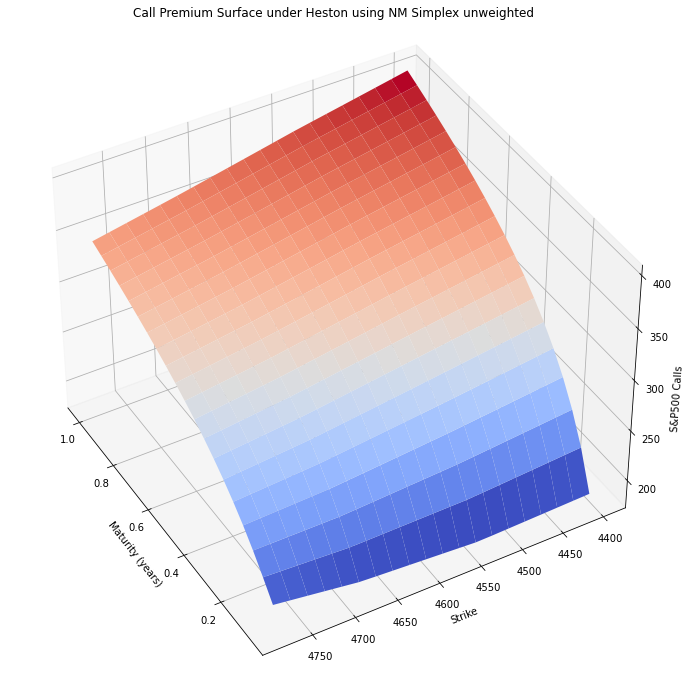

In [16]:
# Heston Surface
premiumSur(K0, lenK, T0, lenT, spot, heston_equal_NM[0], 'Heston', 'NM Simplex', 'unweighted')

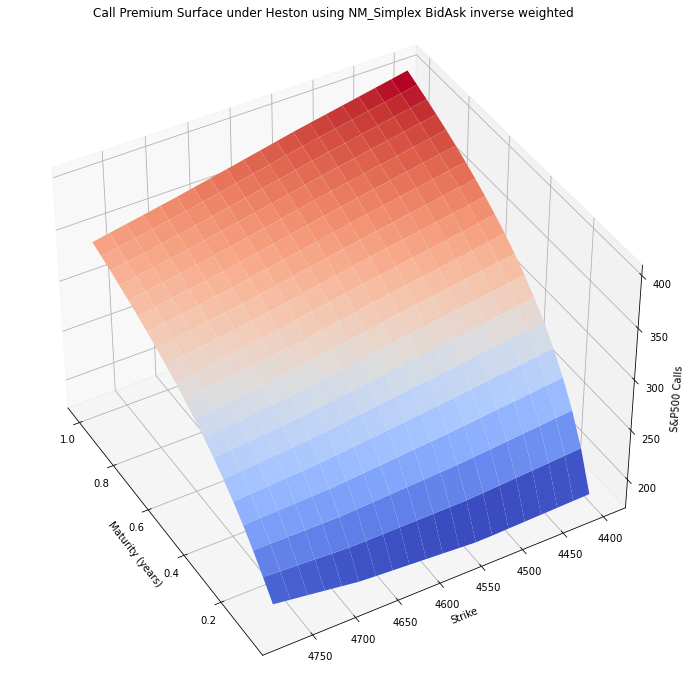

In [17]:
premiumSur(K0, lenK, T0, lenT, spot, heston_invspread_NM[0], 'Heston', 'NM_Simplex', 'BidAsk inverse weighted')

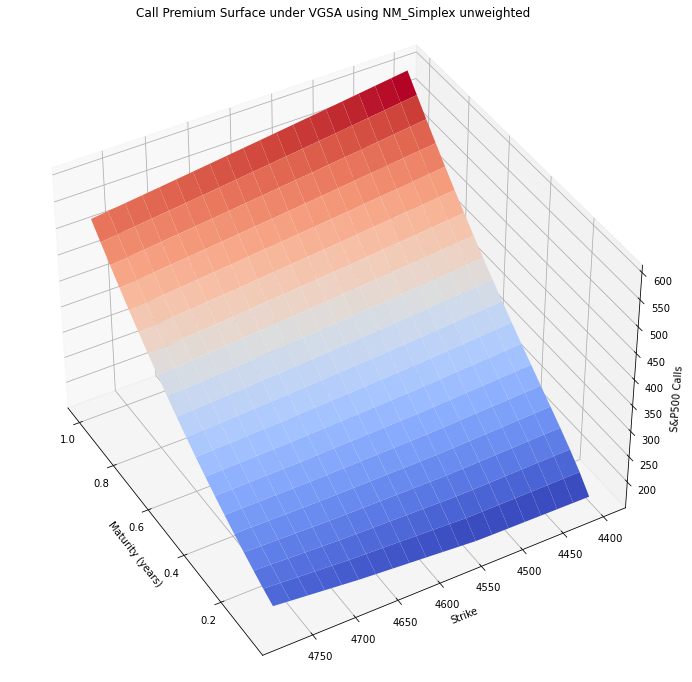

In [18]:
# VGSA surface
premiumSur(K0, lenK, T0, lenT, spot, vgsa_equal_NM[0], 'VGSA', 'NM_Simplex', 'unweighted')

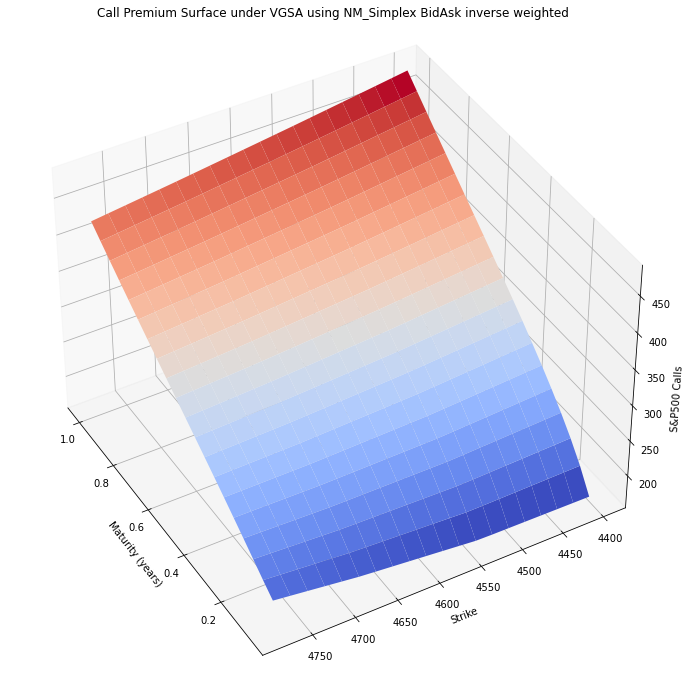

In [19]:
premiumSur(K0, lenK, T0, lenT, spot, vgsa_invspread_NM[0], 'VGSA', 'NM_Simplex', 'BidAsk inverse weighted')

#### Local Volatility Surface Construction

In [20]:
def localVol(K0, ksteps, T0, tsteps, S0, params, model, opt, weight):
    strikes = K0 + 50 * np.arange(ksteps)
    maturities = T0 + 0.05 * np.arange(tsteps)
    marketPrices = np.zeros((ksteps, tsteps))
    
    for i in range(tsteps):
        T = maturities[i]
        km, cT_km = genericFFT(params, S0, K0, rate, q, T, alpha, eta, n_FFT, model)
        marketPrices[:, i] = np.interp(np.log(strikes), km, cT_km)
    
    # use finite difference to estimate the derivative
    localVolatility = np.zeros((ksteps-2, tsteps-2))
    for i in range(1, tsteps-1):
        for j in range(1, ksteps-1):
            dt = (marketPrices[j, i+1] - marketPrices[j, i-1]) / (2*0.05)
            dk = (marketPrices[j+1, i] - marketPrices[j-1, i]) / (2*50)
            dk_second = (marketPrices[j+1, i] - 2*marketPrices[j, i] + marketPrices[j-1, i]) / (50**2)
            c = marketPrices[j, i]
            localVolatility[j-1, i-1] = np.sqrt(2 * (dt + q*c + (rate-q)*strikes[j]*dk) / (strikes[j]**2 * dk_second))
    
    # print(localVolatility)
    
    fig = plt.figure(figsize=(12.,12.))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(maturities[1:tsteps-1], strikes[1:ksteps-1])

    ax.plot_surface(X, Y, localVolatility, cmap=cm.coolwarm)
    ax.set_xlabel('Maturity (years)')
    ax.set_ylabel('Strike')
    ax.set_zlabel('Local Volatility')
    ax.view_init(40, 150)
    plt.title('Local Vol Surface under ' + model + ' using ' + opt + ' ' + weight)
    plt.show()


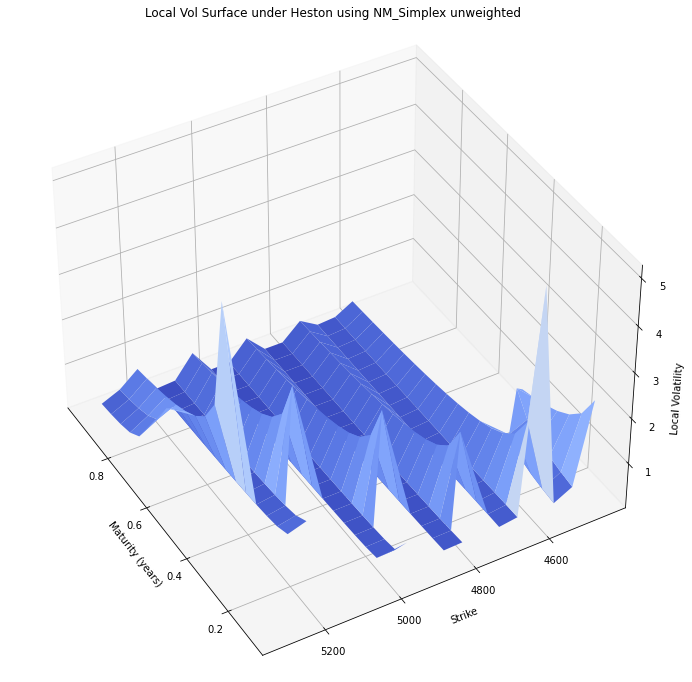

In [21]:
localVol(K0, lenK, T0, lenT, spot, heston_equal_NM[0], 'Heston', 'NM_Simplex', 'unweighted')

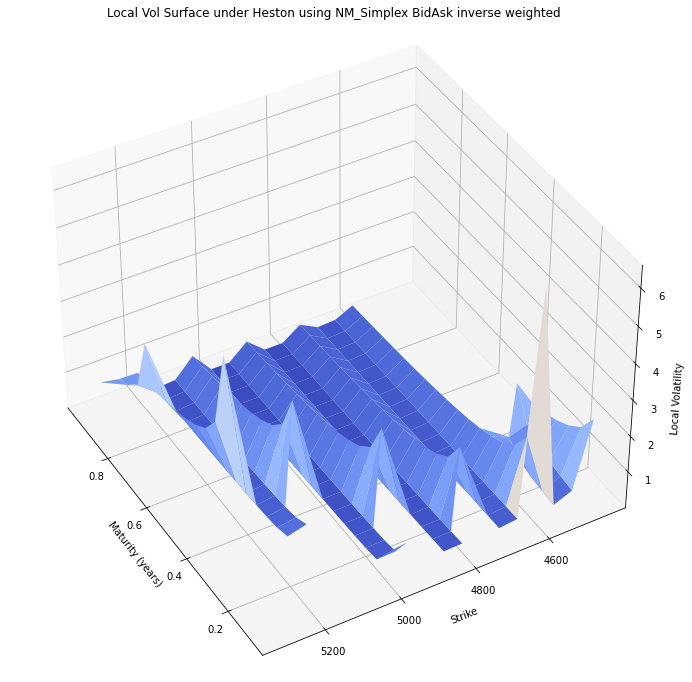

In [22]:
localVol(K0, lenK, T0, lenT, spot, heston_invspread_NM[0], 'Heston', 'NM_Simplex', 'BidAsk inverse weighted')

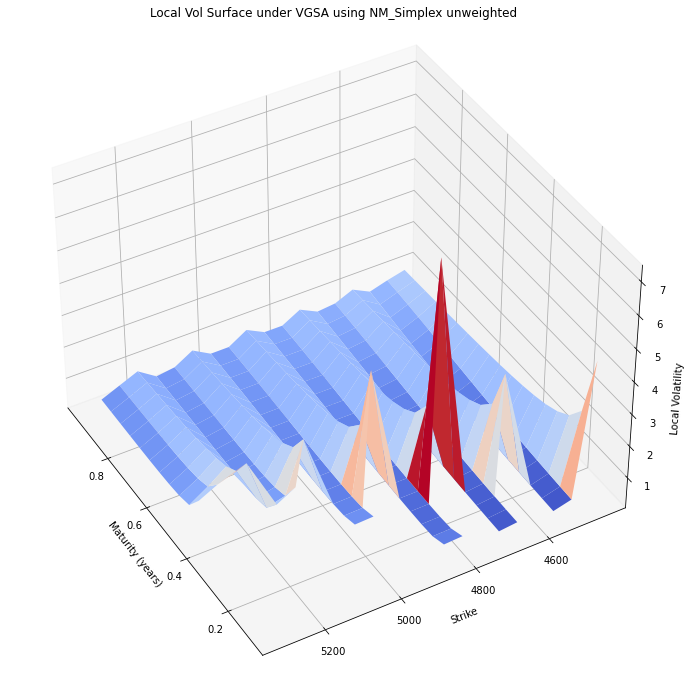

In [23]:
localVol(K0, lenK, T0, lenT, spot, vgsa_equal_NM[0], 'VGSA', 'NM_Simplex', 'unweighted')

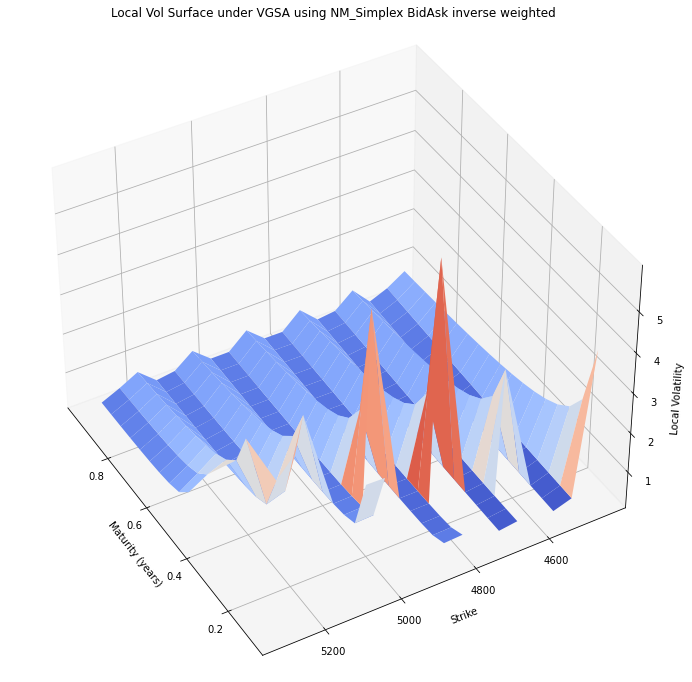

In [24]:
localVol(K0, lenK, T0, lenT, spot, vgsa_invspread_NM[0], 'VGSA', 'NM_Simplex', 'BidAsk inverse weighted')

#### Observation and Findings

1. Local vol across different models

    Under same optimization scheme, we can see that the local volatitlity surface of VGSA model is more smooth, with fewer peaks. However, in terms of the range of the local vol, Heston model is much smaller than that of VGSA model, which makes sense since the nature of VGSA process is to incorporate jumps in the price process. Therefore, we should expect a higher the vol in VGSA model.

2. Local vol across different optimization weight
    
    Based on the plot, the bid ask inverse weighted optimization scheme can give us a lower volatility compared to the equal weighted scheme. This is also intuitive because for those with high bid ask spread, the option is less frequently traded. The price of these options should be quite sensitive to the change of parameters such as strike and maturity. In optimization, if we treat them equally with those liquid options, we will introduce a higher volatility to our surface.